# Boundary conditions in 1D

**Reflecting Boundary Conditions**

Reflecting boundary conditions, also known as Neumann boundary conditions, imply that the flux of particles across the boundary is zero. This can be mathematically expressed as:

$$ \partial_x c \big|_{x = -L} = 0, \quad \partial_x c \big|_{x = L} = 0 \quad. $$

Reflecting boundaries are commonly used in biological systems to model situations where particles, such as molecules or cells, bounce back when they reach the boundary. For example, reflecting boundaries can represent cell membranes or other barriers that prevent particles from leaving a specific region.

**Absorbing Boundary Conditions**

Absorbing boundary conditions, also known as Dirichlet boundary conditions, imply that the concentration of particles at the boundary is zero. This can be mathematically expressed as:

$$ c(-L, t) = 0, \quad c(L, t) = 0 \quad. $$

Absorbing boundaries would be often used in biological systems to model scenarios where particles are removed or degraded upon reaching the boundary.

**Periodic Boundary Conditions**

Periodic boundary conditions imply that the value of the function and its derivatives are the same at the boundaries, creating a continuous loop. This can be mathematically expressed as:

$$ c(-L, t) = c(L, t), \quad \partial_x c \big|_{x = -L} = \partial_x c \big|_{x = L} \quad. $$

Periodic boundaries are favored by computer scientists and computational modelers to simulate infinite or large systems by reducing edge effects. They are commonly used in simulations of lattice models, molecular dynamics, and other computational methods where the system repeats itself.

In [1]:
import numpy as np
from tqdm import tqdm # library to visualize the progress status of a python loop
from euler_scheme_1d_with_growth.functions_for_numerics import *
import matplotlib.pyplot as plt

In [2]:
D     = 1.0  # Diffusion coefficient
beta  = 1.0  # Degradation rate
alpha = 1.0  # Production rate

w     = 1.0  # width of production region

x0    = 0.5  # starting position width of production region
# To highlight the influence of boundaries, 
# let's locate the production region at the edge of the system with some gap x0 from system boundary.

In [3]:
# parameters for Euler scheme

tmax = 2    # time till what to calculate solution
Lmax = 4    # system size boundaries are at the positions -Lmax amd +Lmax

dt   = 1e-3 # time step
dx   = 1e-1 # spatial step

In [4]:
# arrays for space and time coordinates

t   = np.linspace(0, tmax, int(tmax/dt)+1)
ndt = len(t)

**Stability of numerical scheme**

explained in `diffusion_equation/1_solving_diffusion_equation.ipynb`

In [5]:
if D*dt/dx**2 < 0.5:
    print(f'the Courant condition is fullfilled, D*dt/dx**2 = {np.round(D*dt/dx**2, 2)}')
else:
    print(f'the Courant condition is NOT fullfilled, please, revise parameters for Euler scheme')
    print(f'D*dt/dx**2 = {np.round(D*dt/dx**2, 2)}')

the Courant condition is fullfilled, D*dt/dx**2 = 0.1


In [6]:
def chi(x, w, x0=0):
    """
    Shape function of the particles' production region: a rectangular production region 
    starting at position x0 with width w.
    Parameters:
    x  : np.array - spatial coordinates
    w  : float   - size of production region centered at x = 0
    Returns:
    np.array
    """
    return (x >= x0) * (x <= x0 + w)# * 1/w

In [7]:
def G(x, D, beta):
    """
    Green's function of operator D d^2 - beta
    explained in example_notebooks/diffusion_equation/2_diffusion_degradation_production
    Parameters:
    x   :  np.array - spatial coordinates
    D   :  float - diffusion coefficient 
    beta:  float - degradation rate
    Returns:
    np.array
    """
    lam = np.sqrt(D/beta)
    return np.exp(-np.abs(x)/lam)/np.sqrt(D*beta)/2

**To highlight the influence of boundaries, let's locate the production region at the edge of the system with some gap $x_0$ from system boundary.**

In [8]:
def euler_scheme(dx, Lmax, dt, ndt, D, beta, alpha, w, boundary=None):
    """
    Function to find numerically the solution of diffisuon equation with different boundary conditions using Euler scheme.
    Parameters:
    dx      :  float - spatial bin size
    Lmax    :  float - system size
    dt      :  float - temporal bin size
    ndt     :  int   - numver of time steps
    D       :  float - diffusion coefficient 
    beta    :  float - degradation rate
    alpha   :  float - production rate
    w       :  float - production region widthc
    boundary:  str   - boundary conditions, by default None, 'reflect' or 'absorb'
    Returns:
    ct : list - concentration profiles at different time points
    """
    
    # additional bins to implement reflecting boundary conditions
    if boundary==None:
        Lmax = Lmax * 5 # system size, boundaries are far away ~ infinity
        x   = np.linspace(-dx-Lmax, Lmax+dx, 2*int(Lmax/dx)+1+2)
    else:
        x   = np.linspace(-dx, Lmax+dx, int(Lmax/dx)+1+2)
    ndx = len(x)

    # list for the spatial profiles of concentration c as function of time
    ct = []

    # inital conditions: zero concentration profile
    c0 = np.zeros_like(x)
    ct.append(c0)

    # loop through time 
    for n in tqdm( range(1, ndt) ):
        c_n = ct[-1]   
        c_nplus = c_n + (D * numerical_laplacian(c_n, dx) - beta * c_n) * dt
        # morphogen is produced only in real bins
        prod = alpha * chi(x, w, x0) * dt
        prod[-1] = prod[1] = 0
        c_nplus = c_nplus + prod
        
        if boundary=='period':
            ct.append(c_nplus)
        elif boundary=='reflect':
            # 'returning' the concentration 'leaked' to the additional bins
            c_nplus[1]  = c_nplus[1] + c_nplus[0]
            c_nplus[-2] = c_nplus[-2] + c_nplus[-1]
            c_nplus[0]  = c_nplus[-1] = 0
            ct.append(c_nplus)
        elif boundary=='absorb':
            # 'absorb' the concentration 'leaked' to the additional bins
            c_nplus[0]  = c_nplus[-1] = c_nplus[1] = c_nplus[-2] = 0
            ct.append(c_nplus)
    # removing additional bins
    ct = [cn[1:-1 ]for cn in ct]
    
    return x[1:-1], ct

In [9]:
x_prd, ct_prd  = euler_scheme(dx, Lmax, dt, ndt, D, beta, alpha, w, boundary='period')

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 17432.72it/s]


In [10]:
x_abs, ct_abs  = euler_scheme(dx, Lmax, dt, ndt, D, beta, alpha, w, boundary='absorb')

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 17437.83it/s]


In [11]:
x_refl, ct_refl  = euler_scheme(dx, Lmax, dt, ndt, D, beta, alpha, w, boundary='reflect')

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 17283.34it/s]


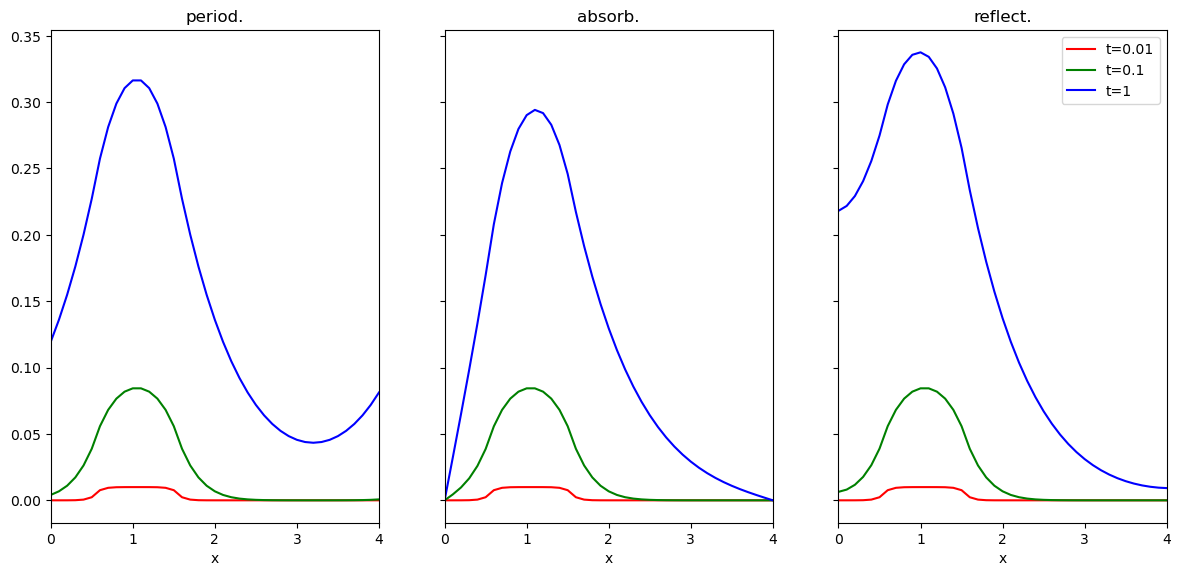

In [12]:
titles = ['period.', 'absorb.', 'reflect.']
x  = [x_prd,  x_abs,  x_refl]
ct = [ct_prd, ct_abs, ct_refl]

figsize_y, figsize_x = plt.rcParams['figure.figsize']
nrows, ncols = 1, len(x)
colors = ['red', 'green', 'blue']

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*figsize_x, nrows*figsize_y), sharex=True, sharey=True)

for j in range(1, ncols*nrows+1):
    ax = plt.subplot(nrows, ncols, j)
    i = 0
    for t in [0.01, 0.1, 1]:
        ax.plot(x[j-1], ct[j-1][int(t/dt)], color=colors[i], label=f't={t}')
        i = i + 1
    ax.set_title(titles[j-1])
    ax.set_xlabel('x')
    if j==0:
        ax.set_ylabel('c(x, t)')
    ax.set_xlim(-0, Lmax)
    
plt.legend()
plt.show()

# Boundary Conditions with Method of Images

When solving diffusion equations with specific boundary conditions, the **Method of Images** can be useful. This method involves placing "image" sources and sinks at strategic locations to satisfy the desired boundary conditions. This technique is can be adapted to all discussed here types of boundary conditions: reflecting, absorbing, periodic boundaries. To get analytically accurate solution one would need to sum the infinite amount these "image", here, as an approximation let's just sum a few, for example, 6.

**Reflecting Boundary Conditions**

The image source is "reflected" from the boundary.

In [13]:
# let's make an approximation for infinite system containing 6x of initial system [0, L]
x_6x = np.concatenate([x_refl + Lmax*i for i in range(-3, 3)])

In [14]:
# Method of images for source with reflecting boundaries
prod = alpha * chi(x_refl, w, x0)
source_refl = np.concatenate([np.flip(prod), prod, np.flip(prod), prod, np.flip(prod), prod])

In [15]:
# steady state with refecting boundaries
steady_refl = np.convolve(G(x_6x, D, beta), source_refl, mode='same') * dx
steady_refl = steady_refl[np.where(x_6x==x_refl[0])[0][0]:np.where(x_6x==x_refl[-1])[0][0]+1]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


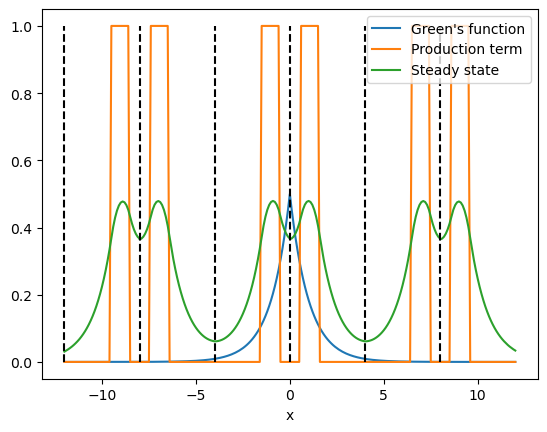

In [16]:
plt.plot( x_6x, G(x_6x, D, beta), label='Green\'s function')
plt.plot( x_6x, source_refl, label='Production term')
plt.plot( x_6x, np.convolve(G(x_6x, D, beta), source_refl, mode='same') * dx, label='Steady state')

for x_bound in [Lmax*i for i in range(-3, 3)]:
    plt.vlines(x_bound, 0, 1, linestyles='dashed', color='black')
    
plt.xlabel('x')
plt.legend()
plt.savefig('fig/refl_bound_method_of_images.pdf', bbox_inches='tight', format='eps')
plt.show()

**Absorving Boundary Conditions**

The image source is "reflected" from the boundary with another sign.

In [17]:
# Method of images for source with reflecting boundaries
prod = alpha * chi(x_refl, w, x0)
source_abs = np.concatenate([-np.flip(prod), prod, -np.flip(prod), prod, -np.flip(prod), prod])

In [18]:
# steady state with refecting boundaries
steady_abs = np.convolve(G(x_6x, D, beta), source_abs, mode='same') * dx
steady_abs = steady_abs[np.where(x_6x==x_refl[0])[0][0]:np.where(x_6x==x_refl[-1])[0][0]+1]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


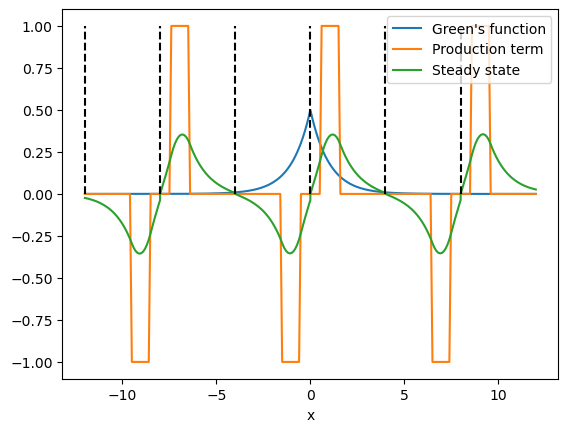

In [19]:
plt.plot( x_6x, G(x_6x, D, beta), label='Green\'s function')
plt.plot( x_6x, source_abs, label='Production term')
plt.plot( x_6x, np.convolve(G(x_6x, D, beta), source_abs, mode='same') * dx, label='Steady state')

for x_bound in [Lmax*i for i in range(-3, 3)]:
    plt.vlines(x_bound, 0, 1, linestyles='dashed', color='black')
    
plt.xlabel('x')
plt.legend()
plt.savefig('fig/abs_bound_method_of_images.pdf', bbox_inches='tight', format='eps')
plt.show()

**Perioduc Boundary Conditions**

The system consists of periodically repeating identical units.

In [20]:
# Method of images for source with reflecting boundaries
prod = alpha * chi(x_refl, w, x0)
source_prd = np.concatenate([prod for i in range(-3, 3)])

In [21]:
# steady state with refecting boundaries
steady_prd = np.convolve(G(x_6x, D, beta), source_prd, mode='same') * dx
steady_prd = steady_prd[np.where(x_6x==x_refl[0])[0][0]:np.where(x_6x==x_refl[-1])[0][0]+1]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


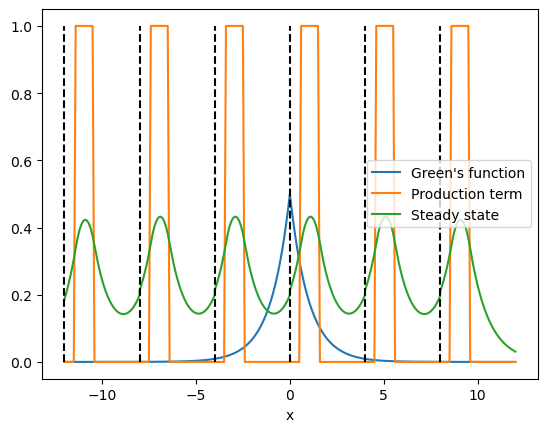

In [22]:
plt.plot( x_6x, G(x_6x, D, beta), label='Green\'s function')
plt.plot( x_6x, source_prd, label='Production term')
plt.plot( x_6x, np.convolve(G(x_6x, D, beta), source_prd, mode='same') * dx, label='Steady state')

for x_bound in [Lmax*i for i in range(-3, 3)]:
    plt.vlines(x_bound, 0, 1, linestyles='dashed', color='black')
    
plt.xlabel('x')
plt.legend()
plt.savefig('fig/periodic_bound_method_of_images.pdf', bbox_inches='tight', format='eps')
plt.show()

# Diffusion dynamics relaxes to steady

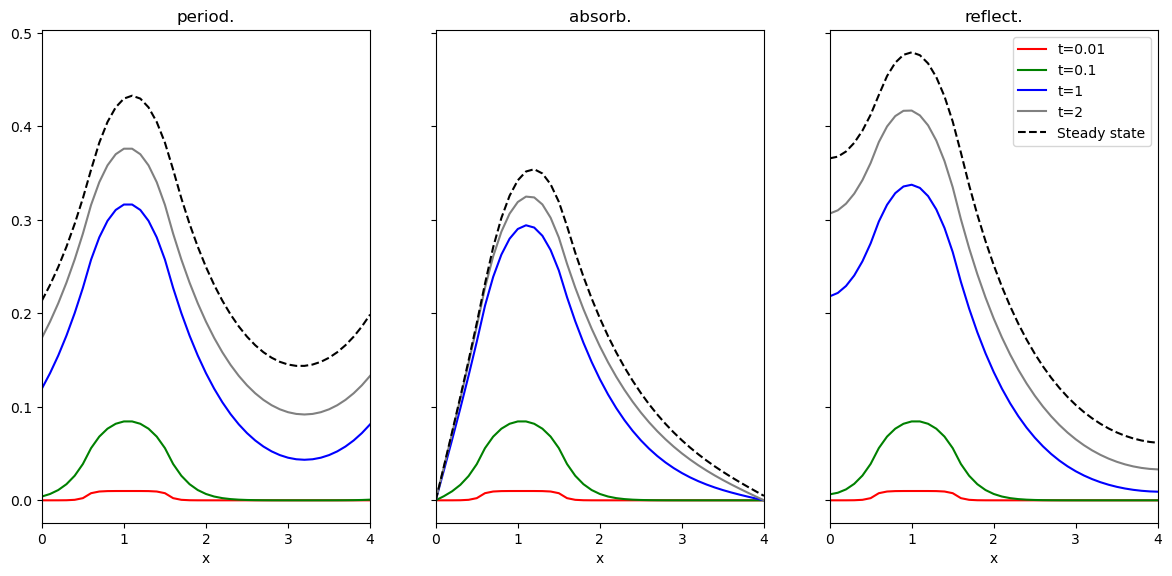

In [23]:
titles = ['period.', 'absorb.', 'reflect.']
x  = [x_prd,  x_abs,  x_refl]
ct = [ct_prd, ct_abs, ct_refl]
st = [steady_prd, steady_abs, steady_refl]

figsize_y, figsize_x = plt.rcParams['figure.figsize']
nrows, ncols = 1, len(x)
colors = ['red', 'green', 'blue', 'gray']

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*figsize_x, nrows*figsize_y), sharex=True, sharey=True)

for j in range(1, ncols*nrows+1):
    ax = plt.subplot(nrows, ncols, j)
    i = 0
    for t in [0.01, 0.1, 1, 2]:
        ax.plot(x[j-1], ct[j-1][int(t/dt)], color=colors[i], label=f't={t}')
        i = i + 1
    plt.plot( x[j-1], st[j-1], '--', color='black', label='Steady state')
    ax.set_title(titles[j-1])
    ax.set_xlabel('x')
    if j==0:
        ax.set_ylabel('c(x, t)')
    ax.set_xlim(0, Lmax)
    
plt.legend()
plt.show()